In [1]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras
import keras.layers as layers
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.metrics import confusion_matrix

2024-05-25 15:02:35.186781: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 15:02:35.702815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
DataSolarModules = pd.read_json('InfraredSolarModules/module_metadata.json').transpose().sort_index()
Classes = DataSolarModules['anomaly_class'].unique()
class_to_number = dict(enumerate(Classes.flatten(), 0))
class_to_number = {v: k for k, v in class_to_number.items()}

In [3]:
def map_to_class(value):
    class_to_number
    return class_to_number.get(value, 'Unknown')

DataSolarModules['class_code'] = DataSolarModules['anomaly_class'].apply(map_to_class)

In [4]:
def read_images_dataframe(dataframe):
    images = []
    for image_path in dataframe['image_filepath']:
        img = cv2.imread("InfraredSolarModules/"+image_path,cv2.IMREAD_GRAYSCALE)
        img = img.reshape(40, 24).astype("float32") / 255
        images.append(img)
    images=np.array(images) 
    return images

def read_labels_dataframe(dataframe):
    labels = []
    for label in dataframe['class_code']:
        labels.append(label)
    labels=np.array(labels) 
    labels.astype("int32")   
    return labels

In [5]:
images = read_images_dataframe(DataSolarModules)
labels = read_labels_dataframe(DataSolarModules)

In [6]:
inputs = keras.Input(shape=(40, 24, 1))


x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)

x = layers.Dense(2048, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(128, activation="relu")(x)


outputs = layers.Dense(12, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

2024-05-25 15:02:39.319841: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-25 15:02:39.349915: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-25 15:02:39.350129: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40, 24, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 38, 22, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 11, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 9, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,386,956 (16.73 MB)

 Trainable params: 4,386,956 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
batch_size = 64
n_epochs = 25

optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

rkf = RepeatedKFold(n_splits=6, n_repeats=3, random_state=21312312)
datos = list(range(0,len(DataSolarModules)))

data_train, data_test = train_test_split(datos, test_size=0.2)


model.compile(optimizer=optimizer,                                    
              loss="sparse_categorical_crossentropy",                 
              metrics=["accuracy"])   

In [8]:
fold_no = 1
acc_per_fold = []
loss_per_fold = []

all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []

for train, val in rkf.split(data_train):

    history_model = model.fit(images[train], labels[train],
                              epochs=n_epochs,
                              validation_data=(images[val], labels[val]),
                              batch_size=batch_size)

    # Store metrics for this fold
    fold_train_loss = np.mean(history_model.history['loss'])
    fold_train_accuracy = np.mean(history_model.history['accuracy'])
    fold_val_loss = np.mean(history_model.history['val_loss'])
    fold_val_accuracy = np.mean(history_model.history['val_accuracy'])

    all_train_losses.append(fold_train_loss)
    all_train_accuracies.append(fold_train_accuracy)
    all_val_losses.append(fold_val_loss)
    all_val_accuracies.append(fold_val_accuracy)

    # Generate generalization metrics for the last epoch
    scores = model.evaluate(images[val], labels[val],verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no += 1

Epoch 1/25


I0000 00:00:1716620560.767325   61403 service.cc:145] XLA service 0x783880010280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716620560.767347   61403 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-05-25 15:02:40.802403: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-25 15:02:40.983829: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


109/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3401 - loss: 2.1426

I0000 00:00:1716620565.141767   61403 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3541 - loss: 2.0941

I0000 00:00:1716620581.558461   61624 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716620581.728331   61629 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 308 bytes spill stores, 308 bytes spill loads

I0000 00:00:1716620582.247346   61608 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716620583.846407   61731 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 264 bytes spill stores, 264 bytes spill loads

I0000 00:00:1716620583.862920   61733 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 308 bytes spill stores, 308 bytes spill loads

I0000 00:00:1716620584.321261 

209/209 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - accuracy: 0.3542 - loss: 2.0938 - val_accuracy: 0.3716 - val_loss: 1.9720
Epoch 2/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3857 - loss: 1.9457 - val_accuracy: 0.3761 - val_loss: 1.9002
Epoch 3/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4115 - loss: 1.8376 - val_accuracy: 0.4631 - val_loss: 1.6491
Epoch 4/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4817 - loss: 1.6208 - val_accuracy: 0.5223 - val_loss: 1.5040
Epoch 5/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5425 - loss: 1.4556 - val_accuracy: 0.5557 - val_loss: 1.3873
Epoch 6/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5544 - loss: 1.3926 - val_accuracy: 0.5939 - val_loss: 1.2851
Epoch 7/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5822 - loss: 1.3094 - val_accuracy: 0.5936 - val_loss: 1.2737
Epoch 8/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5848 - loss: 1.2684 - val_accuracy: 0.6209 - va

I0000 00:00:1716620593.694222   63222 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1716620593.861597   63234 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716620593.941279   63227 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716620595.115333   63338 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 8 bytes spill stores, 16 bytes spill loads

I0000 00:00:1716620595.467118   63349 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_103', 8 bytes spill stores, 8 bytes spill loads



Score for fold 1: loss of 0.9532210230827332; compile_metrics of 69.74128484725952%
Epoch 1/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7393 - loss: 0.7787 - val_accuracy: 0.7769 - val_loss: 0.6595
Epoch 2/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7455 - loss: 0.7520 - val_accuracy: 0.7570 - val_loss: 0.6854
Epoch 3/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7557 - loss: 0.7320 - val_accuracy: 0.7642 - val_loss: 0.6652
Epoch 4/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7639 - loss: 0.7008 - val_accuracy: 0.7690 - val_loss: 0.6594
Epoch 5/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7731 - loss: 0.6713 - val_accuracy: 0.7492 - val_loss: 0.7306
Epoch 6/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7753 - loss: 0.6569 - val_accuracy: 0.7720 - val_loss: 0.6754
Epoch 7/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7776 - loss: 0.6505 - val_accuracy: 0.7672 - val_loss: 0.6866
Epoch 8/25
209/209 ━

I0000 00:00:1716620638.794204   67936 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1716620638.933714   67949 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 308 bytes spill stores, 308 bytes spill loads

I0000 00:00:1716620639.475362   67926 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 264 bytes spill stores, 264 bytes spill loads



209/209 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - accuracy: 0.9209 - loss: 0.2669 - val_accuracy: 0.9767 - val_loss: 0.0908
Epoch 2/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9247 - loss: 0.2356 - val_accuracy: 0.9677 - val_loss: 0.1065
Epoch 3/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9255 - loss: 0.2287 - val_accuracy: 0.9741 - val_loss: 0.0909
Epoch 4/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9285 - loss: 0.2264 - val_accuracy: 0.9696 - val_loss: 0.0892
Epoch 5/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9310 - loss: 0.2128 - val_accuracy: 0.9681 - val_loss: 0.0951
Epoch 6/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9307 - loss: 0.2145 - val_accuracy: 0.9681 - val_loss: 0.1103
Epoch 7/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9317 - loss: 0.2134 - val_accuracy: 0.9587 - val_loss: 0.1199
Epoch 8/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9374 - loss: 0.2012 - val_accuracy: 0.9629 - va

I0000 00:00:1716620648.686991   69429 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_103', 8 bytes spill stores, 8 bytes spill loads



Score for fold 5: loss of 0.2304305136203766; compile_metrics of 92.34808683395386%
Epoch 1/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9291 - loss: 0.2360 - val_accuracy: 0.9846 - val_loss: 0.0595
Epoch 2/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9423 - loss: 0.1962 - val_accuracy: 0.9812 - val_loss: 0.0590
Epoch 3/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9365 - loss: 0.2026 - val_accuracy: 0.9861 - val_loss: 0.0495
Epoch 4/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9438 - loss: 0.1714 - val_accuracy: 0.9857 - val_loss: 0.0476
Epoch 5/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9500 - loss: 0.1705 - val_accuracy: 0.9764 - val_loss: 0.0784
Epoch 6/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9449 - loss: 0.1741 - val_accuracy: 0.9824 - val_loss: 0.0625
Epoch 7/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9532 - loss: 0.1533 - val_accuracy: 0.9666 - val_loss: 0.0940
Epoch 8/25
209/209 ━

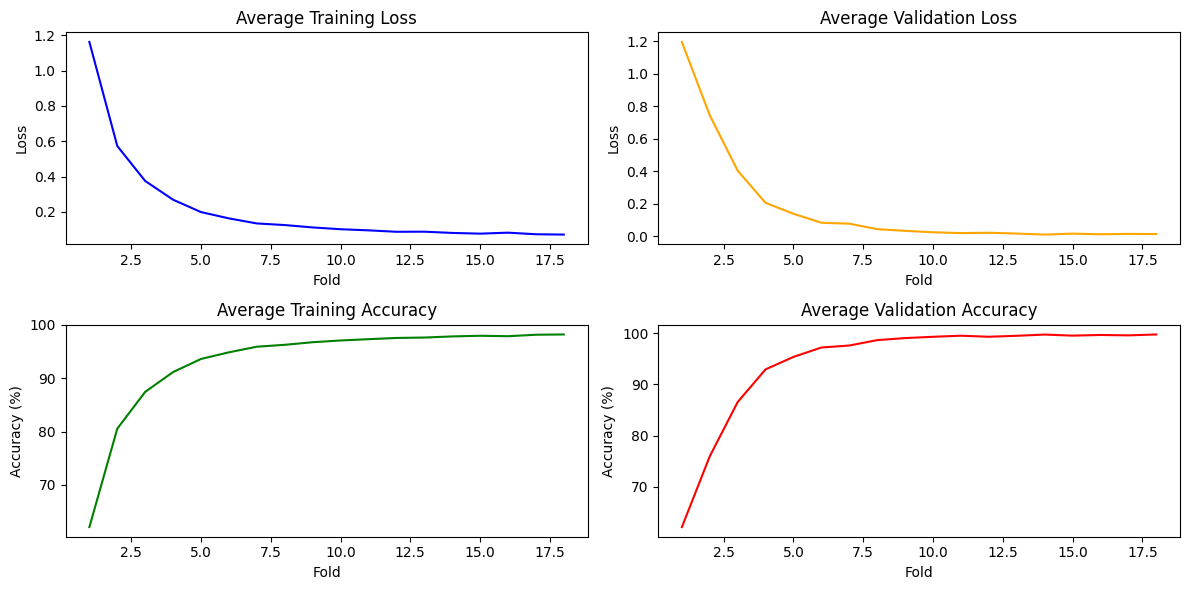

In [9]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(range(1, len(all_train_losses) + 1), all_train_losses, color='blue')
plt.title('Average Training Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')

plt.subplot(2, 2, 2)
plt.plot(range(1, len(all_val_losses) + 1), all_val_losses, color='orange')
plt.title('Average Validation Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')

plt.subplot(2, 2, 3)
plt.plot(range(1, len(all_train_accuracies) + 1), [acc * 100 for acc in all_train_accuracies], color='green')
plt.title('Average Training Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')

plt.subplot(2, 2, 4)
plt.plot(range(1, len(all_val_accuracies) + 1), [acc * 100 for acc in all_val_accuracies], color='red')
plt.title('Average Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

In [10]:
test_metrics = model.evaluate(images[data_test], labels[data_test])  
print("Test loss:", test_metrics[0])
print("Test accuracy:", test_metrics[1])

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - accuracy: 0.9856 - loss: 0.0543
Test loss: 0.05808957666158676
Test accuracy: 0.987500011920929


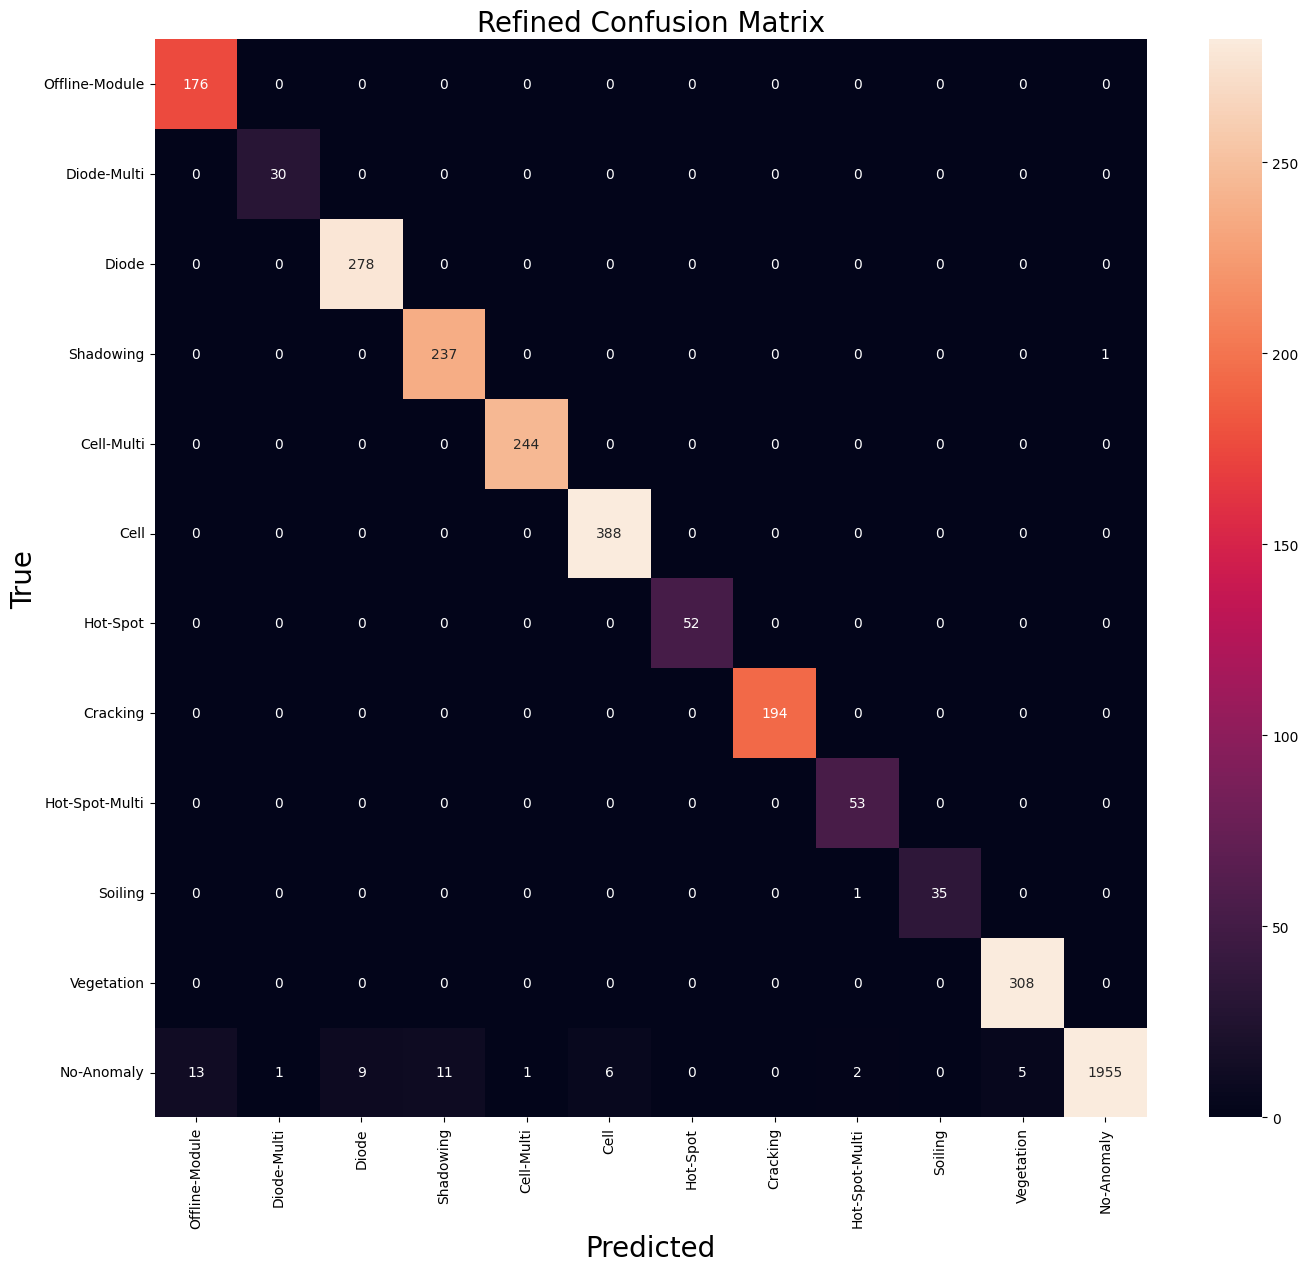

In [11]:
### Confusion Matrix
predictions = model.predict(images[data_test], steps=len(data_test), verbose=0)

y_pred = np.argmax(predictions, axis=-1)

cm = confusion_matrix(labels[data_test], y_pred)

## Get Class Labels
class_names = Classes

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True,robust=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.show()

In [12]:
tp_and_fn = cm.sum(1)
tp_and_fp = cm.sum(0)
tp = cm.diagonal()
accuracy = cm.diagonal().sum()/cm.sum()
precision = tp / tp_and_fp
recall = tp / tp_and_fn
f1 = 2 * (precision * recall) / (precision + recall)
precision_avg=np.average(precision)
recall_avg=np.average(recall)
f1_avg=np.average(f1)

In [13]:
# Creating a dictionary with the data
data = {
    'Metrics': ['Accuracy', 'Average Precision', 'Average Recall', 'Average F1 Score'],
    'Values': [accuracy, precision_avg, recall_avg, f1_avg]
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)

             Metrics    Values
0           Accuracy  0.987500
1  Average Precision  0.977823
2     Average Recall  0.995338
3   Average F1 Score  0.986301


In [14]:
data = {
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)

             Class  Precision    Recall  F1 Score
0   Offline-Module   0.931217  1.000000  0.964384
1      Diode-Multi   0.967742  1.000000  0.983607
2            Diode   0.968641  1.000000  0.984071
3        Shadowing   0.955645  0.995798  0.975309
4       Cell-Multi   0.995918  1.000000  0.997955
5             Cell   0.984772  1.000000  0.992327
6         Hot-Spot   1.000000  1.000000  1.000000
7         Cracking   1.000000  1.000000  1.000000
8   Hot-Spot-Multi   0.946429  1.000000  0.972477
9          Soiling   1.000000  0.972222  0.985915
10      Vegetation   0.984026  1.000000  0.991948
11      No-Anomaly   0.999489  0.976036  0.987623
